In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.RandomAffine(25, translate=(0.2,0.2), scale=(1,2), shear=10, resample=False, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.RandomAffine(25, translate=(0.2,0.2), scale=(1,2), shear=10, resample=False, fillcolor=0),                                                                
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

### With classic CNN


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306324
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.272155


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.9266, Accuracy: 3955/10000 (40%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.988329
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.914139

Test set: Average loss: 1.4993, Accuracy: 5366/10000 (54%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.777952
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.874303

Test set: Average loss: 1.2911, Accuracy: 6296/10000 (63%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.579499
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.568559

Test set: Average loss: 1.1489, Accuracy: 6774/10000 (68%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 1.507657
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.617926

Test set: Average loss: 1.0027, Accuracy: 7215/10000 (72%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 1.318601
Train Epoch: 6 [32000/60000 (53%)]	Loss: 1.357871

Test set: Average loss: 0.9337, Accuracy: 7401/10000 (74%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 1.448814
Train Epoch: 7 [32000/60000 (53%)]	Loss: 1.163086

Test set: Average loss: 0.8355, Accuracy: 7684/10000 (77%)

Tra

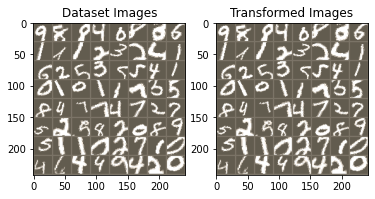

In [10]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

#### WIth spatial transformer




/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.382767
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.239860


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.5248, Accuracy: 5306/10000 (53%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.726060
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.296812

Test set: Average loss: 0.8673, Accuracy: 7341/10000 (73%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.018256
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.211134

Test set: Average loss: 0.6241, Accuracy: 8201/10000 (82%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.035989
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.699676

Test set: Average loss: 0.4891, Accuracy: 8565/10000 (86%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.874986
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.520097

Test set: Average loss: 0.5393, Accuracy: 8346/10000 (83%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.738985
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.749522

Test set: Average loss: 0.4239, Accuracy: 8728/10000 (87%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.610725
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.684717

Test set: Average loss: 0.3908, Accuracy: 8779/10000 (88%)

Tra

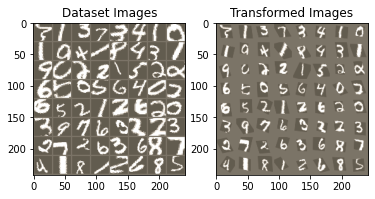

In [14]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

We can see that without the spatial transformer, the network is not able to learn a specific area of interest and as a consequence, its accuary is less important be cause he is more sensitive to variation.